In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.utils import resample
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve, average_precision_score
import tensorflow as tf
from transformers import BertTokenizer, TFBertModel

2025-05-29 02:32:17.928724: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748485938.172037      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748485938.238010      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
df = pd.read_csv('/kaggle/input/sentiment-analysis-for-mental-health/Combined Data.csv')

if 'Unnamed: 0' in df.columns:
    df.drop('Unnamed: 0', axis=1, inplace=True)

df.dropna(subset=['statement', 'status'], inplace=True)
df.drop_duplicates(inplace=True)
df.reset_index(drop=True, inplace=True)

print(df.head())


                                           statement   status
0                                         oh my gosh  Anxiety
1  trouble sleeping, confused mind, restless hear...  Anxiety
2  All wrong, back off dear, forward doubt. Stay ...  Anxiety
3  I've shifted my focus to something else but I'...  Anxiety
4  I'm restless and restless, it's been a month n...  Anxiety


In [3]:
# Resample to balance classes 
max_count = df['status'].value_counts().max()
df_bal = pd.DataFrame()
for status, grp in df.groupby('status'):
    if len(grp) < max_count:
        grp_res = resample(grp, replace=True, n_samples=max_count, random_state=42)
    else:
        grp_res = grp
    df_bal = pd.concat([df_bal, grp_res])

df_bal.reset_index(drop=True, inplace=True)
print("After resampling:\n", df_bal['status'].value_counts())

df = df_bal


After resampling:
 status
Anxiety                 16040
Bipolar                 16040
Depression              16040
Normal                  16040
Personality disorder    16040
Stress                  16040
Suicidal                16040
Name: count, dtype: int64


In [4]:
# Build dynamic label map and one-hot labels
target_names = sorted(df['status'].unique())
num_classes = len(target_names)
label_map = {label: idx for idx, label in enumerate(target_names)}
df['label'] = df['status'].map(label_map)

In [5]:
# Tokenize with BERT
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
MAX_LEN = 128
enc = tokenizer(
    df['statement'].astype(str).tolist(), padding='max_length', truncation=True,
    max_length=MAX_LEN, return_tensors='np'
)
input_ids = enc['input_ids']
attention_mask = enc['attention_mask']


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [6]:
# Prepare labels and tf.data dataset
labels = tf.keras.utils.to_categorical(df['label'], num_classes=num_classes)
dataset = tf.data.Dataset.from_tensor_slices(
    ({'input_ids': input_ids, 'attention_mask': attention_mask}, labels)
)

I0000 00:00:1748486181.853735      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1748486181.854378      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


In [7]:
# Train/val/test split
BATCH = 32
dataset = dataset.shuffle(buffer_size=len(df), seed=42)
n = len(df)
n_train = int(0.8 * n)
n_val = int(0.1 * n)
train_ds = dataset.take(n_train).batch(BATCH)
val_ds = dataset.skip(n_train).take(n_val).batch(BATCH)
test_ds = dataset.skip(n_train + n_val).batch(BATCH)


In [8]:
# Build model
def build_model():
    bert = TFBertModel.from_pretrained('bert-base-uncased')
    in_ids = tf.keras.Input(shape=(MAX_LEN,), dtype=tf.int32, name='input_ids')
    in_mask = tf.keras.Input(shape=(MAX_LEN,), dtype=tf.int32, name='attention_mask')
    x = bert(in_ids, attention_mask=in_mask).pooler_output
    x = tf.keras.layers.Dropout(0.5)(x)
    x = tf.keras.layers.Dense(256, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    out = tf.keras.layers.Dense(num_classes, activation='softmax')(x)
    return tf.keras.Model(inputs=[in_ids, in_mask], outputs=out)

model = build_model()
model.summary()

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_ids (InputLayer)      [(None, 128)]                0         []                            
                                                                                                  
 attention_mask (InputLayer  [(None, 128)]                0         []                            
 )                                                                                                
                                                                                                  
 tf_bert_model (TFBertModel  TFBaseModelOutputWithPooli   1094822   ['input_ids[0][0]',           
 )                           ngAndCrossAttentions(last_   40         'attention_mask[0][0]']      
                             hidden_state=(None, 128, 7                                       

In [9]:
# Compile model
optim = tf.keras.optimizers.Adam(learning_rate=5e-5, epsilon=1e-8)
metrics = ['accuracy']
for cls, idx in label_map.items():
    metrics += [
        tf.keras.metrics.Precision(name=f"prec_{cls}", class_id=idx),
        tf.keras.metrics.Recall(name=f"rec_{cls}", class_id=idx)
    ]

model.compile(
    optimizer=optim,
    loss='categorical_crossentropy',
    metrics=metrics
)


In [10]:
# Train
epochs = 10
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
    tf.keras.callbacks.ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True)
]
hist = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=callbacks
)

Epoch 1/10


I0000 00:00:1748486229.273795      99 service.cc:148] XLA service 0x7f8a24b70ba0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1748486229.274365      99 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1748486229.274386      99 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1748486229.358071      99 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1748486229.484001      99 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


2807/2807 [==============================] - ETA: 0s - loss: 0.4574 - accuracy: 0.8336 - prec_Anxiety: 0.9316 - rec_Anxiety: 0.8562 - prec_Bipolar: 0.9393 - rec_Bipolar: 0.8630 - prec_Depression: 0.7453 - rec_Depression: 0.6040 - prec_Normal: 0.9356 - rec_Normal: 0.8698 - prec_Personality disorder: 0.9510 - rec_Personality disorder: 0.8955 - prec_Stress: 0.8910 - rec_Stress: 0.8242 - prec_Suicidal: 0.7358 - rec_Suicidal: 0.7142

/usr/local/lib/python3.11/dist-packages/tf_keras/src/engine/training.py:3098: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2807/2807 [==============================] - 2476s 865ms/step - loss: 0.4574 - accuracy: 0.8336 - prec_Anxiety: 0.9316 - rec_Anxiety: 0.8562 - prec_Bipolar: 0.9393 - rec_Bipolar: 0.8630 - prec_Depression: 0.7453 - rec_Depression: 0.6040 - prec_Normal: 0.9356 - rec_Normal: 0.8698 - prec_Personality disorder: 0.9510 - rec_Personality disorder: 0.8955 - prec_Stress: 0.8910 - rec_Stress: 0.8242 - prec_Suicidal: 0.7358 - rec_Suicidal: 0.7142 - val_loss: 0.1892 - val_accuracy: 0.9253 - val_prec_Anxiety: 0.9775 - val_rec_Anxiety: 0.9726 - val_prec_Bipolar: 0.9813 - val_rec_Bipolar: 0.9869 - val_prec_Depression: 0.9101 - val_rec_Depression: 0.6488 - val_prec_Normal: 0.9595 - val_rec_Normal: 0.9589 - val_prec_Personality disorder: 0.9851 - val_rec_Personality disorder: 1.0000 - val_prec_Stress: 0.9671 - val_rec_Stress: 0.9788 - val_prec_Suicidal: 0.7584 - val_rec_Suicidal: 0.9155
Epoch 2/10
2807/2807 [==============================] - 2434s 867ms/step - loss: 0.1953 - accuracy: 0.9296 - prec_An

In [11]:
# Evaluate predictions
y_true, y_score = [], []
for x_batch, y_batch in test_ds:
    probs = model.predict(x_batch)
    y_score.append(probs)
    y_true.extend(np.argmax(y_batch.numpy(), axis=1))
y_score = np.vstack(y_score)

y_pred = np.argmax(y_score, axis=1)

1/1 [==============================] - 4s 4s/step


In [12]:
# Classification report
print(classification_report(y_true, y_pred, target_names=target_names, digits=4))

                      precision    recall  f1-score   support

             Anxiety     0.9938    0.9994    0.9966      1610
             Bipolar     0.9976    0.9982    0.9979      1650
          Depression     0.9845    0.9937    0.9891      1597
              Normal     0.9994    0.9943    0.9968      1584
Personality disorder     0.9994    1.0000    0.9997      1582
              Stress     0.9955    0.9994    0.9974      1548
            Suicidal     0.9982    0.9837    0.9909      1657

            accuracy                         0.9955     11228
           macro avg     0.9955    0.9955    0.9955     11228
        weighted avg     0.9955    0.9955    0.9955     11228



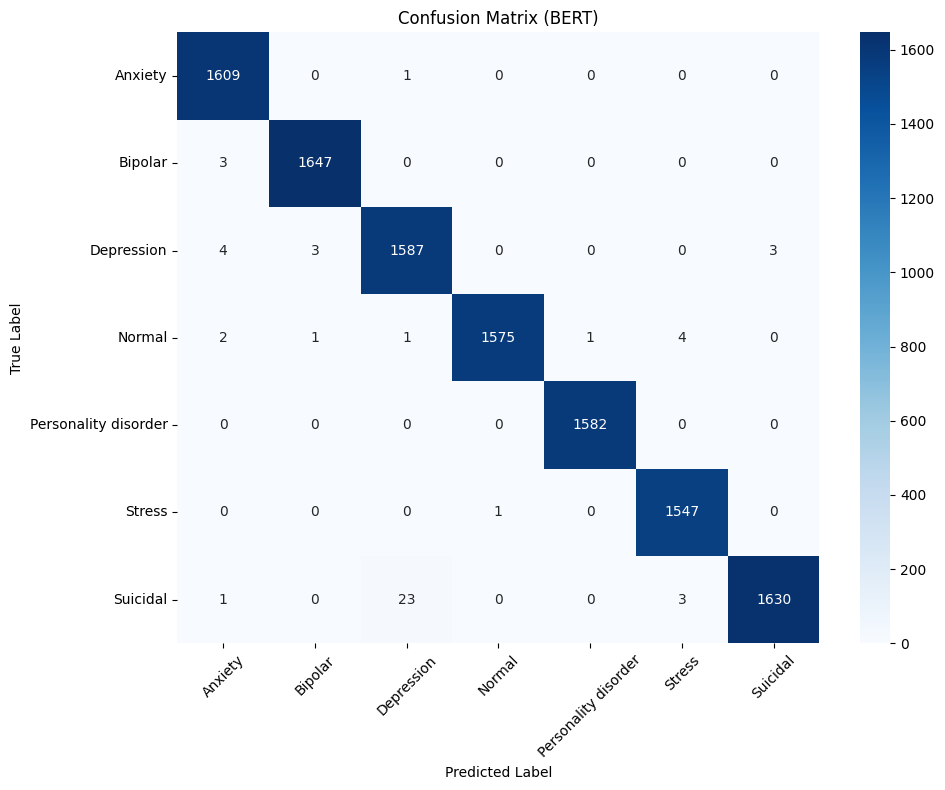

In [22]:
# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=target_names, yticklabels=target_names)
plt.title('Confusion Matrix (BERT)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

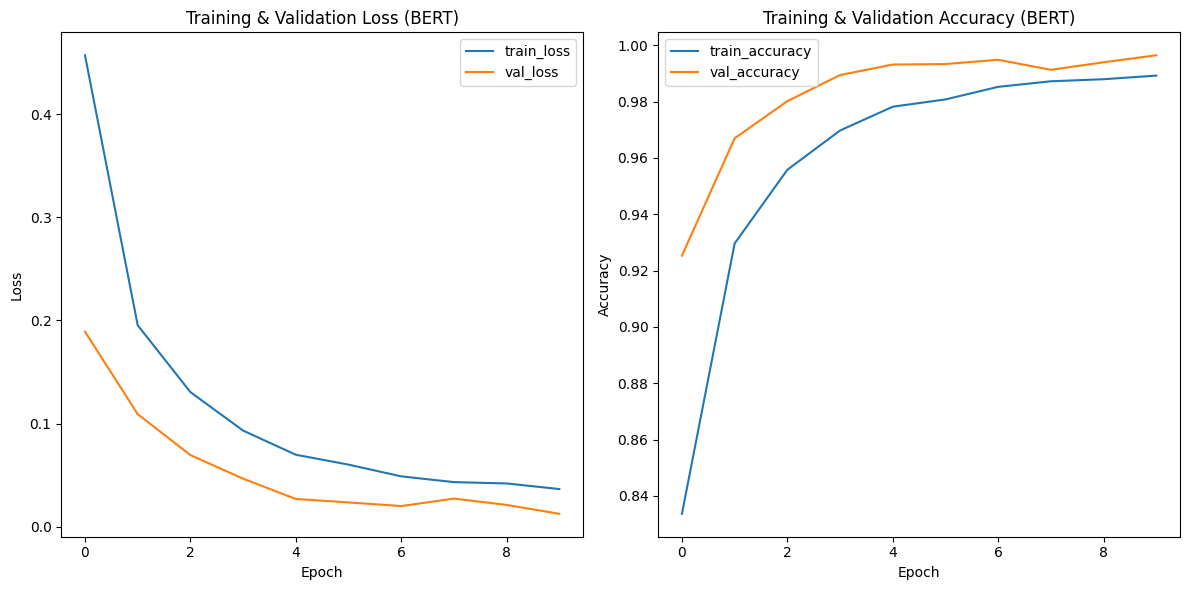

In [23]:
# Plot training & validation loss and accuracy
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(hist.history['loss'], label='train_loss')
plt.plot(hist.history['val_loss'], label='val_loss')
plt.title('Training & Validation Loss (BERT)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(hist.history['accuracy'], label='train_accuracy')
plt.plot(hist.history['val_accuracy'], label='val_accuracy')
plt.title('Training & Validation Accuracy (BERT)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.show()


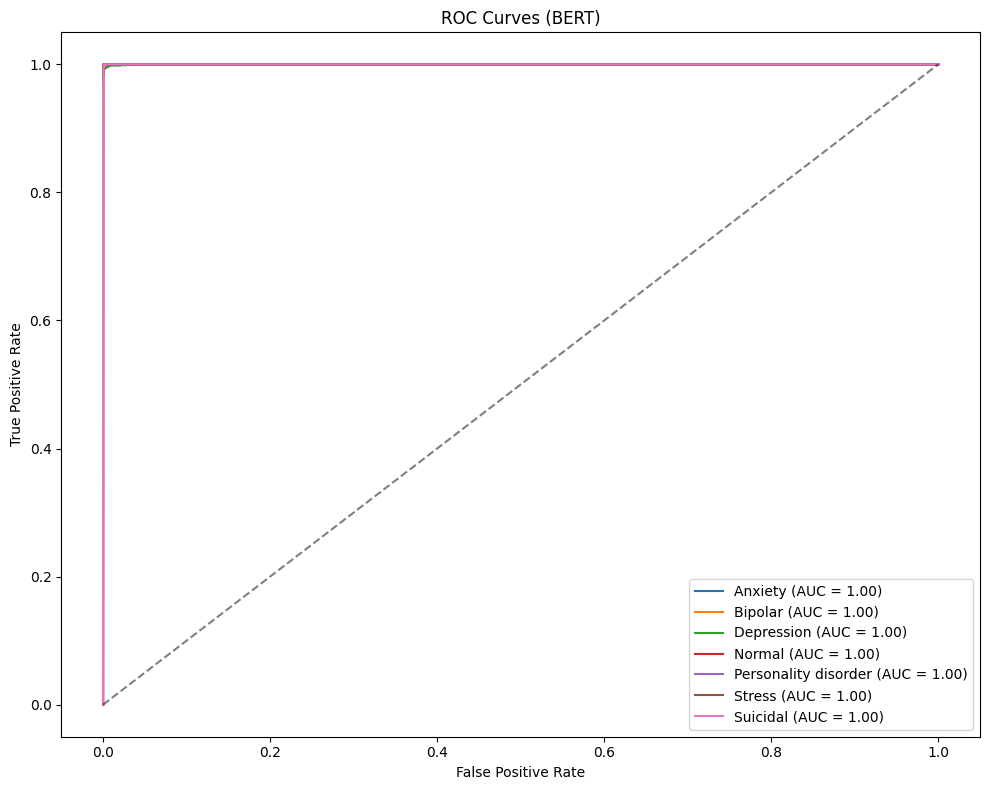

In [24]:
# ROC Curves 
# One-hot encode true labels for ROC/PR
from tensorflow.keras.utils import to_categorical
y_true_bin = to_categorical(y_true, num_classes=num_classes)

plt.figure(figsize=(10, 8))
for i, cls in enumerate(target_names):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_score[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{cls} (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], 'k--', alpha=0.5)
plt.title('ROC Curves (BERT)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()


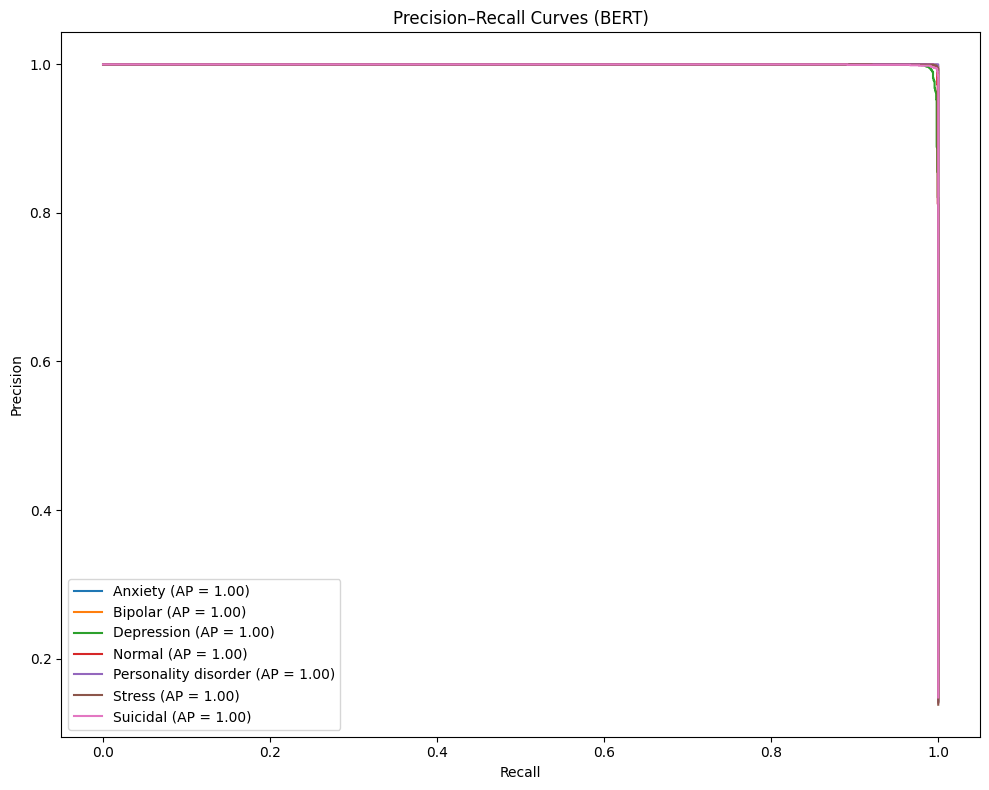

In [25]:
# Precision–Recall Curves
plt.figure(figsize=(10, 8))
for i, cls in enumerate(target_names):
    precision, recall, _ = precision_recall_curve(y_true_bin[:, i], y_score[:, i])
    ap = average_precision_score(y_true_bin[:, i], y_score[:, i])
    plt.plot(recall, precision, label=f"{cls} (AP = {ap:.2f})")
plt.title('Precision–Recall Curves (BERT)')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc='lower left')
plt.tight_layout()
plt.show()
